In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os, glob, inspect, sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/marie-anne/code/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Import data

In [3]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,std_MBN,median_CF_g,mean_CF_g,std_CF_g,median_perm_g,mean_perm_g,std_perm_g,median_pMBN_g,mean_pMBN_g,std_pMBN_g
T_B1,12.947951,0.073112,0.000234,0.000018,0.0175,0.0042,0.001264,0.000519,4.410000e-13,4.090000e-07,...,0.127282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B2,12.920068,0.077814,0.000571,0.000139,0.0240,0.0057,0.002486,0.000816,1.520000e-06,1.510000e-06,...,0.110443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B3,12.932865,0.088762,0.000244,0.000030,0.0134,0.0028,0.001168,0.000555,4.270000e-13,5.640000e-07,...,0.178157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B4,10.763517,0.071173,0.000379,0.000100,0.0146,0.0031,0.002084,0.000648,7.580000e-07,1.000000e-06,...,0.052547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B5,12.942958,0.074808,0.000230,0.000033,0.0182,0.0040,0.001141,0.000447,3.970000e-13,4.670000e-07,...,0.042655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculating new values

In [4]:
calc_df = mc.updated_df(df, mc.measures_list, mc.errors_list)

In [5]:
calc_df.describe()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,mean_CF_UB,mean_perm_UB,mean_MBN_UB,mean_CF_g_UB,mean_perm_g_UB,mean_pMBN_g_UB,AUC_avg,AUC_LB,AUC_UB,CF_perm
count,24.000000,24.000000,16.000000,16.000000,24.000000,16.000000,24.000000,24.000000,2.400000e+01,2.400000e+01,...,24.000000,24.000000,24.000000,8.000000,8.000000,8.000000,2.400000e+01,2.400000e+01,2.400000e+01,24.000000
mean,12.444946,0.094940,0.000356,0.000058,0.022125,0.004994,0.001851,0.000611,2.139557e-07,5.654833e-07,...,1.822804,78.999628,0.624929,1.045359,122.415019,0.733929,2.191276e+29,-3.082447e+32,3.086829e+32,0.035708
std,0.882849,0.024646,0.000108,0.000037,0.005491,0.001762,0.000614,0.000220,5.191123e-07,4.960846e-07,...,1.374562,30.530656,0.261966,0.356661,20.551191,0.320290,5.316607e+29,2.701088e+32,2.707234e+32,0.046948
min,10.763517,0.071173,0.000230,0.000018,0.013400,0.002800,0.000933,0.000210,2.010000e-13,9.860000e-08,...,0.684982,33.343728,0.307519,0.560895,83.640677,0.118188,2.058598e+23,-9.431157e+32,5.373251e+31,0.004611
25%,12.114038,0.077206,0.000273,0.000028,0.018125,0.003700,0.001373,0.000445,4.260000e-13,1.262500e-07,...,0.993936,63.035619,0.420057,0.901279,117.562287,0.614704,4.363003e+23,-3.672279e+32,6.873007e+31,0.008649
50%,12.926379,0.090211,0.000340,0.000049,0.022600,0.004650,0.001747,0.000598,1.152100e-10,4.440000e-07,...,1.124616,69.288131,0.594378,0.943838,124.250330,0.834045,1.179950e+26,-2.422169e+32,2.422169e+32,0.016523
75%,12.985953,0.102029,0.000415,0.000078,0.025700,0.005825,0.002148,0.000788,9.282500e-08,6.730000e-07,...,2.118732,107.016020,0.727303,1.161633,129.929706,0.918169,9.506884e+28,-6.861151e+31,3.676161e+32,0.026517
max,13.169977,0.182199,0.000571,0.000139,0.035900,0.008700,0.003377,0.001147,2.070000e-06,1.730000e-06,...,4.786578,138.008377,1.214995,1.733224,153.463592,1.087872,2.120038e+30,-5.360080e+31,9.434106e+32,0.139586


## Scaling values

In [6]:
scaled_df = mc.scale_general(calc_df, MinMaxScaler())[0]
scaled_df.head()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,mean_CF_UB,mean_perm_UB,mean_MBN_UB,mean_CF_g_UB,mean_perm_g_UB,mean_pMBN_g_UB,AUC_avg,AUC_LB,AUC_UB,CF_perm
T_B1,0.907738,0.017461,0.010566,0.000000,0.182222,0.237288,0.135434,0.330382,1.159420e-07,0.190266,...,0.104611,0.344640,0.334634,NaN,NaN,NaN,1.159429e-07,0.809257,0.190560,0.084813
T_B2,0.896151,0.059814,1.000000,1.000000,0.471111,0.491525,0.635434,0.646362,7.342995e-01,0.865146,...,0.106924,0.323728,0.446710,NaN,NaN,NaN,7.342995e-01,0.138599,0.864595,0.089542
T_B3,0.901469,0.158423,0.039918,0.098855,0.000000,0.000000,0.096154,0.368786,1.091788e-07,0.285276,...,0.100306,0.342209,0.510208,NaN,NaN,NaN,1.091795e-07,0.714843,0.284956,0.082766
T_B4,0.000000,0.000000,0.436748,0.678038,0.053333,0.050847,0.470949,0.467570,3.661835e-01,0.552532,...,0.940336,0.000000,0.284536,NaN,NaN,NaN,3.661835e-01,0.445141,0.556354,0.982351
T_B5,0.905663,0.032736,0.000000,0.128237,0.213333,0.203390,0.085106,0.253680,9.468600e-08,0.225818,...,0.186573,0.315581,0.297579,NaN,NaN,NaN,9.468692e-08,0.773564,0.226246,0.128844


## Selecting sub samples

In [7]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(calc_df)

In [8]:
tube_scaled, pipe_scaled, tube_wo_blind_scaled, tube_blind_scaled = mc.get_subsample_df(scaled_df)

In [11]:
short_scaled_df = scaled_df.copy().loc[:,mc.without_std_g_list]
tube_scaled_short, pipe_scaled_short, \
tube_wo_blind_scaled_short, tube_blind_scaled_short = mc.get_subsample_df(short_scaled_df)

In [12]:
selected_scaled_df = scaled_df.copy().loc[:,mc.correlation_list_and_LB_UB]
tube_scaled_selected, pipe_scaled_selected, \
tube_wo_blind_scaled_selected, tube_blind_scaled_selected = mc.get_subsample_df(selected_scaled_df)

In [13]:
corr_scaled_df = scaled_df.copy().loc[:,mc.correlation_list]
tube_scaled_corr, pipe_scaled_corr, \
tube_wo_blind_scaled_corr, tube_blind_scaled_corr = mc.get_subsample_df(corr_scaled_df)

# Clustering

In [95]:
tube_scaled_corr

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,AUC_avg,CF_perm
T_B1,0.907738,0.182222,0.135434,0.154523,1.159429e-07,0.084813
T_B2,0.896151,0.471111,0.635434,0.695701,7.342995e-01,0.089542
T_B3,0.901469,0.000000,0.096154,0.121720,1.091795e-07,0.082766
T_B4,0.000000,0.053333,0.470949,0.488414,3.661835e-01,0.982351
T_B5,0.905663,0.213333,0.085106,0.000000,9.468692e-08,0.128844
T_B6,0.113989,0.062222,0.159574,0.344919,5.550729e-07,0.982398
T_B7,0.880394,0.737778,0.398936,0.617951,1.357522e-07,0.012918
T_B8,0.620941,0.600000,0.000000,0.063791,2.038165e-06,0.227326
T_AR,0.907355,0.200000,0.132570,0.574400,1.169091e-07,0.113836
T_N,0.017291,0.528889,0.898118,0.541039,6.956513e-02,0.963141


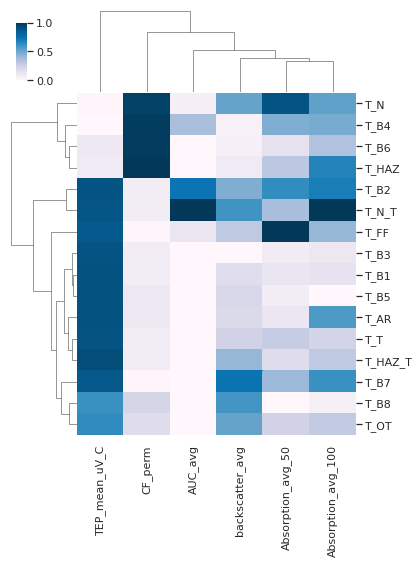

In [94]:
sns.clustermap(tube_scaled_corr, method='ward', metric='euclidean', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

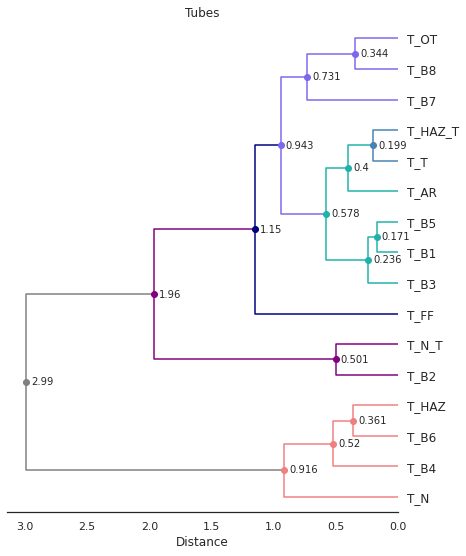

In [59]:
sns.set_theme(style="white")

Z = hierarchy.linkage(tube_scaled_corr,
method='ward',
metric='euclidean')

ax, fig = plt.subplots(figsize=(7,9))
color = 4*['gray',  
           'lightseagreen',  'steelblue', 'lightseagreen', 'mediumslateblue', 'lightcoral',
           'lightseagreen',  'purple',  'lightcoral',  'lightseagreen',
            'mediumslateblue',  'lightcoral', 'mediumslateblue', 'navy', 'purple']

dendro = hierarchy.dendrogram(Z, labels=tube_scaled_corr.index, leaf_rotation=0, orientation='left',
                         link_color_func=lambda k: color[k])
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    #if y > 0:
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )


plt.xlabel('Distance')
plt.title('Tubes')
sns.despine(left=True)

# Cophenetic Correlation Coefficient 
Calculate the cophenetic distances between each observation in the hierarchical clustering defined by the linkage Z.

Suppose that the original data {Xi} have been modeled using a cluster method to produce a dendrogram {Ti}; that is, a simplified model in which data that are "close" have been grouped into a hierarchical tree. Define the following distance measures.
- x(i, j) = | Xi − Xj |, the ordinary Euclidean distance between the ith and jth observations.
- t(i, j) = the dendrogrammatic distance between the model points Ti and Tj. This distance is the height of the node at which these two points are first joined together.

Then, letting x ¯ {\displaystyle {\bar {x}}} {\bar {x}} be the average of the x(i, j), and letting t ¯ {\displaystyle {\bar {t}}} {\bar {t}} be the average of the t(i, j), the cophenetic correlation coefficient c is given by



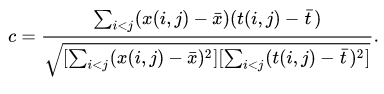

In [108]:
# The closer the value is to 1, the better the clustering preserves the original distances.
c, coph_dists = hierarchy.cophenet(Z, pdist(tube_scaled_corr))
print(c)
coph_dists

0.9098908232002303


array([1.96362506, 0.2363563 , 2.99437563, 0.17123391, 2.99437563,
       0.94276974, 0.94276974, 0.57794685, 2.99437563, 1.96362506,
       0.57794685, 0.94276974, 1.15100413, 2.99437563, 0.57794685,
       1.96362506, 2.99437563, 1.96362506, 2.99437563, 1.96362506,
       1.96362506, 1.96362506, 2.99437563, 0.50127616, 1.96362506,
       1.96362506, 1.96362506, 2.99437563, 1.96362506, 2.99437563,
       0.2363563 , 2.99437563, 0.94276974, 0.94276974, 0.57794685,
       2.99437563, 1.96362506, 0.57794685, 0.94276974, 1.15100413,
       2.99437563, 0.57794685, 2.99437563, 0.51963605, 2.99437563,
       2.99437563, 2.99437563, 0.91564264, 2.99437563, 2.99437563,
       2.99437563, 2.99437563, 0.51963605, 2.99437563, 2.99437563,
       0.94276974, 0.94276974, 0.57794685, 2.99437563, 1.96362506,
       0.57794685, 0.94276974, 1.15100413, 2.99437563, 0.57794685,
       2.99437563, 2.99437563, 2.99437563, 0.91564264, 2.99437563,
       2.99437563, 2.99437563, 2.99437563, 0.36136604, 2.99437

In [ ]:
from sklearn import metrics
metrics.silhouette_score(tube_blind_scaled_corr, )

# fcluster
Cluster observation data using a given metric.

Clusters the original observations in the n-by-m data matrix X (n observations in m dimensions), using the euclidean distance metric to calculate distances between original observations, performs hierarchical clustering using the single linkage algorithm, and forms flat clusters using the inconsistency method with t as the cut-off threshold.

In [102]:
hierarchy.fclusterdata(tube_scaled_corr, t=4, criterion='maxclust', method='ward')

array([3, 2, 3, 1, 3, 1, 3, 3, 3, 1, 2, 3, 3, 4, 1, 3], dtype=int32)

In [97]:

depth = 5
incons = hierarchy.inconsistent(Z, depth)
incons
# avg, std, count, inconsistency 

array([[ 0.17123391,  0.        ,  1.        ,  0.        ],
       [ 0.19949787,  0.        ,  1.        ,  0.        ],
       [ 0.20379511,  0.04604848,  2.        ,  0.70710678],
       [ 0.34351111,  0.        ,  1.        ,  0.        ],
       [ 0.36136604,  0.        ,  1.        ,  0.        ],
       [ 0.29981909,  0.14187563,  2.        ,  0.70710678],
       [ 0.50127616,  0.        ,  1.        ,  0.        ],
       [ 0.44050105,  0.11191379,  2.        ,  0.70710678],
       [ 0.31703505,  0.17070697,  5.        ,  1.52841917],
       [ 0.5374402 ,  0.27425715,  2.        ,  0.70710678],
       [ 0.59888158,  0.28550924,  3.        ,  1.10945993],
       [ 0.45035317,  0.27730629,  8.        ,  1.77571365],
       [ 0.52820328,  0.34904467,  9.        ,  1.78430127],
       [ 0.76088877,  0.53771054,  9.        ,  2.23677276],
       [ 1.06590116,  0.81877219, 10.        ,  2.35532482]])

In [83]:
maxinconsts(Z, incons)

array([0.        , 0.        , 0.70710678, 0.        , 0.        ,
       0.70710678, 0.        , 0.70710678, 1.01339897, 0.70710678,
       0.70710678, 1.04856914, 1.04856914, 1.04856914, 1.04856914])

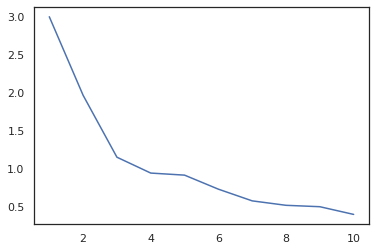

In [75]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

In [81]:
from scipy.cluster.hierarchy import fcluster
fcluster(Z, 1.2, depth=3)

array([3, 2, 3, 1, 3, 1, 5, 5, 4, 1, 2, 4, 5, 6, 1, 4], dtype=int32)

0.9098908232002303

In [30]:
Z

array([[ 4.        ,  5.        ,  0.21686209,  2.        ],
       [ 1.        ,  2.        ,  0.23753799,  2.        ],
       [ 3.        ,  8.        ,  0.27890326,  3.        ],
       [ 6.        ,  7.        ,  0.45053158,  2.        ],
       [ 9.        , 10.        ,  0.75581714,  5.        ],
       [ 0.        , 12.        ,  0.7808899 ,  6.        ],
       [11.        , 13.        ,  1.4979386 ,  8.        ]])

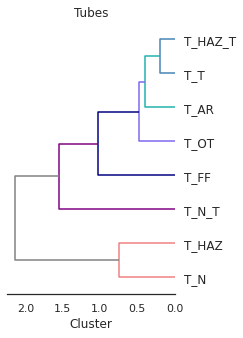

In [20]:
sns.set_theme(style="white")

Z = hierarchy.linkage(tube_wo_blind_scaled_selected,
method='ward',
metric='euclidean')

ax, fig = plt.subplots(figsize=(3,5))
color = 2*['steelblue', 'lightseagreen', 'mediumslateblue', 'lightcoral', 'navy', 'purple', 'gray', 'gray']
d = hierarchy.dendrogram(Z, labels=tub.index, leaf_rotation=0, orientation='left',
                         link_color_func=lambda k: color[k])

plt.xlabel('Distance')
plt.title('Tubes')
sns.despine(left=True)

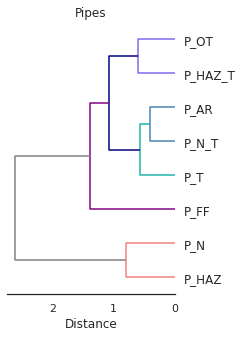

In [25]:
sns.set_theme(style="white")

Z = hierarchy.linkage(pipe_scaled_short,
method='ward',
metric='euclidean')

ax, fig = plt.subplots(figsize=(3,5))
color = 2*['steelblue', 'lightseagreen', 'mediumslateblue', 'lightcoral', 'navy', 'purple', 'gray', 'gray']
d = hierarchy.dendrogram(Z, labels=pipe_scaled_short.index, leaf_rotation=0, orientation='left', 
                         distance_sort='descending',
                         link_color_func=lambda k: color[k])

plt.xlabel('Distance')
plt.title('Pipes')
sns.despine(left=True)

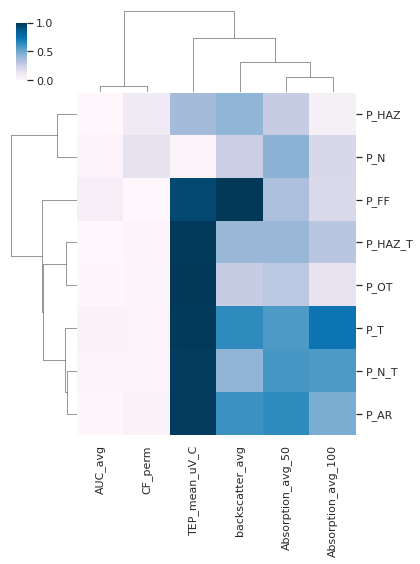

In [26]:
sns.clustermap(pipe_scaled_corr, method='ward', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

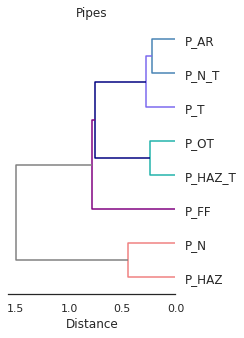

In [27]:
sns.set_theme(style="white")

Z = hierarchy.linkage(pipe_scaled_corr,
method='ward',
metric='euclidean')

ax, fig = plt.subplots(figsize=(3,5))
color = 2*['steelblue', 'lightseagreen', 'mediumslateblue', 'lightcoral', 'navy', 'purple', 'gray', 'gray']
d = hierarchy.dendrogram(Z, labels=pipe_scaled_corr.index, leaf_rotation=0, orientation='left', 
                         distance_sort='descending',
                         link_color_func=lambda k: color[k])

plt.xlabel('Distance')
plt.title('Pipes')
sns.despine(left=True)

In [ ]:
import plotly.figure_factory as ff
import plotly.io as pio
dendro = ff.create_dendrogram(pipe_scaled, distfun='ward')
dendro.update_layout(width=800, height=500)
dendro.show()
pio.write_json(dendro, 'test.plotly')